In [1]:
from import_data import *
from noise_models import *
from PICDNN_extended import *
from Branch_flow_xy_split import *
# from generate_xy import *
import numpy as np
import matplotlib.pyplot as plt
# from volt_to_p_est import *
# from VI_to_P import *
# from linear_models import *
from feature_bins import std_bins_bflow
from IPython.display import clear_output
import matplotlib.pyplot as plt
#%% importing single hour imag dataset
VR, VI, bflow, Pinj, Qinj, CFR, CFI, CTR, CTI = import_curr_branch_data()

In [2]:
def data(addbus=[], output = "vi_all"):
#%% Getting X and Y 
    x_vr, x_vi, x_cr, x_ci,  ytot = Branch_flow_custom_xy_split(bflow, VR, VI, CFR, CFI, CTR, CTI, Pinj, Qinj, output = output,  num_bus = 11, add_bus = addbus)
    #%% Adding noise 
    x_vr_n, x_vi_n = GMM_real_imag(x_vr, x_vi)
    x_cr_n, x_ci_n = GMM_real_imag(x_cr, x_ci)
    # bflow_n = noise_gaussian(X, range1, mu1)
    # bflow_n = NoisyMag(x_bflow.values)
 

    # X_p = VI_to_P(x_vm_n, x_va_n, x_cm_n, x_ca_n, num_bus = 11, add_bus = [])
    X_v = np.concatenate((x_vr_n, x_vi_n, x_cr_n, x_ci_n), axis=1)
    Y_p = ytot
    return X_v, Y_p

In [3]:
bdata = np.genfromtxt(r"System_data\bdata.csv", delimiter=',')

In [4]:
def one_run(add_bus):
    X_v, Y_p = data(add_bus, 'vi_all')
    dnn = Deep_Network(layers=5, nodes=int(X_v.shape[1]*1.25), lr = 1e-4, epoch = 200,
                    batch_norm = True, dropout = 0)
    # dnn.y_normalise = True
    dnn.loss = "mse"
    mse, mape, r2 = dnn.model_parse(X_v,Y_p,Pinj, Qinj, ntest=1)
    return X_v, Y_p, dnn, mse, mape, r2



In [5]:
def create_A_array(bdata, n_buses):
    n = bdata.shape[0]
    A = np.zeros((n_buses, n))
    for i in range(n_buses):
        for j in range(n):
            if bdata[j, 0] == i+1:
                A[i, j] = 1
    return A


def create_C_array(bdata, n_buses):
    n = bdata.shape[0]
    C = np.zeros((n_buses, n))
    for i in range(n_buses):
        for j in range(n):
            if bdata[j, 1] == i+1:
                C[i, j] = 1
    return C

def create_B_array(bdata):
    n = bdata.shape[0]
    B = np.zeros((n, n))
    for i in range(n):
        B[i, i] = 1
    return B

def power_from_vi(vars, A, B, C):
    Pff_v1  = tf.linalg.matmul(vars[0], A)
    Pff_v2  = tf.linalg.matmul(vars[2], B)
    Pff_v3  = tf.linalg.matmul(vars[1], A)
    Pff_v4  = tf.linalg.matmul(vars[3], B)

    Pft_v1  = tf.linalg.matmul(vars[0], C)
    Pft_v2  = tf.linalg.matmul(vars[4], B)
    Pft_v3  = tf.linalg.matmul(vars[1], C)
    Pft_v4  = tf.linalg.matmul(vars[5], B)


    PFF = tf.multiply(tf.add(tf.multiply(Pff_v1, Pff_v2), tf.multiply(Pff_v3, Pff_v4)), 100)
    PFT = tf.multiply(tf.add(tf.multiply(Pft_v1, Pft_v2), tf.multiply(Pft_v3, Pft_v4)), 100)

    return PFF, PFT




def get_errors(X_v, Y_p, dnn, mse, mape, r2):
    _, x_test, _, y_test = train_test_split(X_v, Y_p, test_size=0.2)

    x_test_scaled = dnn.x_scaler.transform(x_test)

    yhat = tf.convert_to_tensor(dnn.model.predict(x_test), dtype=tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)


    bdata = np.genfromtxt(r"System_data\bdata.csv", delimiter=',')
    A = tf.convert_to_tensor(create_A_array(bdata,118), dtype=tf.float32)
    B = tf.convert_to_tensor(create_B_array(bdata), dtype=tf.float32)
    C = tf.convert_to_tensor(create_C_array(bdata, 118), dtype=tf.float32)


    lengths = [118, 118, 186,186,186,186] # VR, VI, CFR, CFI, CTR, CTI

    sample_input = yhat
    vars = tf.split(sample_input, lengths, axis=1)


    vars_actual = tf.split(y_test, lengths, axis=1)

    PFF_actual ,PFT_actual = power_from_vi(vars_actual, A, B, C)
    PFF, PFT = power_from_vi(vars, A, B, C)

    # Compute squared difference
    squared_difference_PFF = tf.square(tf.subtract(PFF, PFF_actual))
    squared_difference_PFT = tf.square(tf.subtract(PFT, PFT_actual))

    # Compute mean
    mean_squared_error_PFF = tf.reduce_mean(squared_difference_PFF)
    mean_squared_error_PFT = tf.reduce_mean(squared_difference_PFT)

    # Compute square root to get RMSE
    rmse_PFF = tf.sqrt(mean_squared_error_PFF)
    rmse_PFT = tf.sqrt(mean_squared_error_PFT)

    # print("Root Mean Squared Error for PFF: ", rmse_PFF)
    # print("Root Mean Squared Error for PFT: ", rmse_PFT)
    
    bflow_hat = reorder(PFF, PFT)
    bflow_actual = reorder(PFF_actual, PFT_actual)
    y = tf.linalg.matmul(bflow_actual, dnn.last_layer_weights2)
    yhat = tf.linalg.matmul(bflow_hat, dnn.last_layer_weights2)
    pinj_error = tf.sqrt(tf.reduce_mean((y-yhat)**2))
    pflowerror = (rmse_PFF+rmse_PFT)/2
    v_error1 = tf.sqrt(tf.reduce_mean((vars[0]-vars_actual[0])**2))
    v_error2 = tf.sqrt(tf.reduce_mean((vars[1]-vars_actual[1])**2))
    v_error = (v_error1+v_error2)/2
    r2_filtered = [x if -1<=x<=1 else 0 for x in r2[0]]
    np.mean(r2_filtered)
    return v_error, pflowerror, pinj_error, r2_filtered



Calculate power injection error

Make loooooop

In [6]:
add_bus =  [100, 49, 77, 89, 12, 59, 37, 32, 19, 104, 97, 67, 112, 41, 3, 94, 6, 28, 79, 13]

v_error_list = []

pflow_error_list = []
pinj_error_list = []
r2_list = []
base_list = []

for additional_bus in add_bus:
    base_list.append(additional_bus)
    X_v, Y_p, dnn, mse, mape, r2 = one_run(base_list)
    v_error, pflowerror, pinj_error, r2_filtered = get_errors(X_v, Y_p, dnn, mse, mape, r2)
    v_error_list.append(v_error)
    pflow_error_list.append(pflowerror)
    pinj_error_list.append(pinj_error)
    r2_list.append(r2_filtered)
    clear_output()

In [21]:
np.mean(r2_list[0])

0.5591259159067263

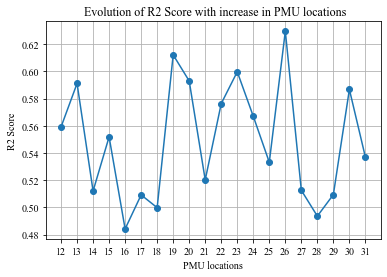

In [114]:
bus_list = [i+12 for i in range(20)]
plt.plot(bus_list,[np.mean(r2_list[i]) for i in range(20)], '-o')
plt.rcParams["font.family"] = "Times New Roman"
plt.xticks(np.arange(12, 32, step=1))
plt.xlabel("PMU locations")
plt.ylabel("R2 Score")
plt.grid()
plt.title(" Evolution of R2 Score with increase in PMU locations")
plt.savefig("Plots/R2Score.pdf", bbox_inches = "tight", format="pdf")

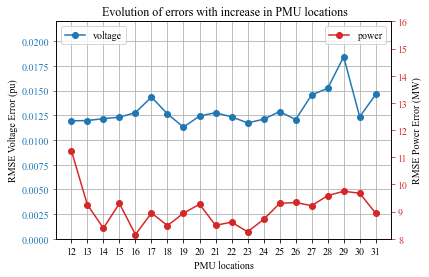

In [113]:
bus_list = [i+12 for i in range(20)]

fig, ax1 = plt.subplots()
plt.rcParams["font.family"] = "Times New Roman"
ax1.plot(bus_list,[v_error_list[i] for i in range(20)], '-o', label = "voltage")
ax1.tick_params('y', colors='#1f77b4')
ax1.set_ylabel("RMSE Voltage Error (pu)")
ax1.set_ylim(0, 0.022)
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(bus_list, [pflow_error_list[i] for i in range(20)], '-o', color='C3', label = "power")
ax2.tick_params('y', colors='C3')
ax2.set_ylabel("RMSE Power Error (MW)")
ax2.set_ylim(8, 16)
ax2.legend(loc=1)

plt.xticks(np.arange(12, 32, step=1))
ax1.set_xlabel("PMU locations")
plt.title(" Evolution of errors with increase in PMU locations")
ax1.grid()
# plt.legend(["Voltage Error", "Power Error"])
# plt.show()
plt.savefig("Plots/RMSE.pdf", bbox_inches = "tight", format="pdf")

In [30]:
_, x_test, _, y_test = train_test_split(X_v, Y_p, test_size=0.2)

x_test_scaled = dnn.x_scaler.transform(x_test)

yhat = tf.convert_to_tensor(dnn.model.predict(x_test), dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)


bdata = np.genfromtxt(r"System_data\bdata.csv", delimiter=',')
A = tf.convert_to_tensor(create_A_array(bdata,118), dtype=tf.float32)
B = tf.convert_to_tensor(create_B_array(bdata), dtype=tf.float32)
C = tf.convert_to_tensor(create_C_array(bdata, 118), dtype=tf.float32)


lengths = [118, 118, 186,186,186,186] # VR, VI, CFR, CFI, CTR, CTI

sample_input = yhat
vars = tf.split(sample_input, lengths, axis=1)


vars_actual = tf.split(y_test, lengths, axis=1)

i_error1 = tf.sqrt(tf.reduce_mean((vars[2]-vars_actual[2])**2))
i_error2 = tf.sqrt(tf.reduce_mean((vars[3]-vars_actual[3])**2))
i_error3 = tf.sqrt(tf.reduce_mean((vars[4]-vars_actual[4])**2))
i_error4 = tf.sqrt(tf.reduce_mean((vars[5]-vars_actual[5])**2))

print(np.mean([i_error1, i_error2, i_error3, i_error4]))

0.06457099


In [9]:
# v_error_list_np = [v_error_list[i].numpy() for i in range(len(v_error_list))]
# pflow_error_list_np = [pflow_error_list[i].numpy() for i in range(len(pflow_error_list))]
# pinj_error_list_np = [pinj_error_list[i].numpy() for i in range(len(pinj_error_list))]
# r2_list_np = [r2_list[i] for i in range(len(r2_list))]

# # Creating a DataFrame
# data = {
#     'V Error': v_error_list_np,
#     'PFlow Error': pflow_error_list_np,
#     'PInj Error': pinj_error_list_np,
#     'R2': r2_list_np
# }

# df = pd.DataFrame(data)

# # Saving to CSV
# csv_filename = 'errors_and_r2.csv'
# df.to_csv(csv_filename, index=False)